In [1]:
from tensorflow import keras
import gc

In [2]:
from CustomLayers import *
from GS_composer import *
from Functions import *
from ClassModel import *

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
#user_profile = "E:/learning resource/"
user_profile = "D:/"
Model_path = user_profile+"OneDrive - The University of Queensland/PhD/HPC_Results/Sugarcane_disease/ML/1Head_RealForm32_32LocalB"
#Model_path = "E:/learning resource/OneDrive - The University of Queensland/PhD/HPC_Results/Sugarcane_disease/ML/"

In [4]:
from keras import backend as K

In [5]:
model_folder = "pachy_MultiHeadAttentionLNN_1"
#model_folder = "test_model"
full_path = Model_path + "/" + model_folder
model = keras.models.load_model(full_path,custom_objects={"MultiHead_QKV_BlockAttention": MultiHead_QKV_BlockAttention,
                                                         "SNPBlockLayer":SNPBlockLayer})

[TensorShape([None, 2608, 32])]
[TensorShape([None, 2608, 32]), TensorShape([None, 2608, 32])]


In [6]:
model.summary()
#model = keras.Model(inputs=input1, outputs=QV_output)
model.compile(optimizer="RMSprop", loss="mean_squared_error")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_1 (InputLayer)      [(None, 26086, 1)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 26086, 1)     0           input_layer_1[0][0]              
__________________________________________________________________________________________________
locally_connected1d (LocallyCon (None, 2608, 32)     834560      zero_padding1d[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 2608, 32)     1056        locally_connected1d[0][0]        
______________________________________________________________________________________________

A test variable of SNP array based on the freq of alleles.

In [22]:

#data = np.ones((1, 26086, 1))
test_filename = user_profile+"OneDrive - The University of Queensland/PhD/data/sugarcane_disease/sugarcane_disease.freqV1.ped"
data = pd.read_csv(test_filename,header=None,sep="\t").iloc[:,6:]
data=np.expand_dims(data,axis=-1)
print(data.shape)

(1, 26086, 1)


Model predict via test freq data

In [23]:
model.predict(data)

I:\miniconda\envs\tf25\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


array([[3.8025415]], dtype=float32)

Extract layer weights and outputs from the model

In [59]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                         outputs=model.get_layer('dense_2').output)

In [60]:
intermediate_output = intermediate_layer_model.predict(data)

In [61]:
attention = intermediate_output[0]
attention = K.expand_dims(attention,axis=1)
print(attention.shape)

(2608, 1, 32)


In [62]:
LNN_weight = model.layers[2].get_weights()

In [63]:
LNN_weight[0].shape

(2608, 10, 32)

In [64]:
LNN_weight[0].shape

(2608, 10, 32)

In [65]:
SNP_attention = tf.multiply(attention,LNN_weight[0])

In [80]:
SNP_attention = tf.reshape(SNP_attention,(26080,1,32))

In [92]:
mean_SNP_attention = SNP_attention
#mean_SNP_attention = tf.reduce_mean(SNP_attention,axis=2)
mean_SNP_attention.shape
#mean_SNP_attention =np.array(tf.reshape(mean_SNP_attention,(26080,))) #np.array(tf.reshape(mean_SNP_attention,(26080*32,)))
mean_SNP_attention =np.array(tf.reshape(mean_SNP_attention,(26080,32)))

In [93]:
import matplotlib.pyplot as plt
import math

In [99]:
np.mean(mean_SNP_attention)

3.273687e-05

(26080, 32)


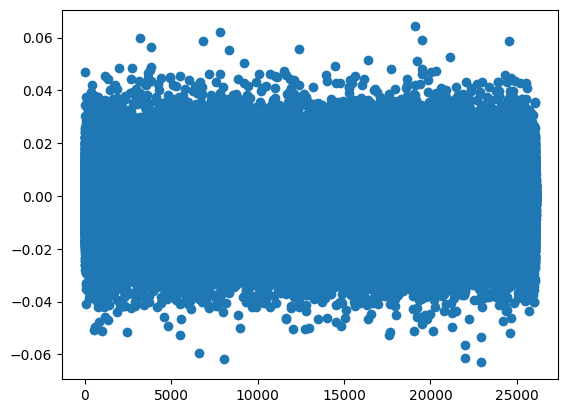

In [104]:
print(mean_SNP_attention.shape)
#plt.scatter(x=np.tile(np.arange(0,26080),1),y=abs(mean_SNP_attention))
plt.scatter(x=np.tile(np.arange(0,26080),32),y=mean_SNP_attention)

In [38]:
mean_SNP_attention.shape

(834560,)

In [51]:
def export_attention_score_by_trait(filename,trait,val):
    model = keras.models.load_model(filename,custom_objects={"MultiHead_QKV_BlockAttention": MultiHead_QKV_BlockAttention,
                                                         "SNPBlockLayer":SNPBlockLayer})
    model.summary()
    #model = keras.Model(inputs=input1, outputs=QV_output)
    model.compile(optimizer="RMSprop", loss="mean_squared_error")
    test_filename = user_profile+"OneDrive - The University of Queensland/PhD/data/sugarcane_disease/sugarcane_disease.freqV1.ped"
    data = pd.read_csv(test_filename,header=None,sep="\t").iloc[:,6:]
    data=np.expand_dims(data,axis=-1)
    print(data.shape)
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                         outputs=model.get_layer('add_3').output)
    intermediate_output = intermediate_layer_model.predict(data)
    attention = intermediate_output[0]
    attention = K.expand_dims(attention,axis=1)
    print(attention.shape)
    
    LNN_weight = model.layers[2].get_weights()
    SNP_attention = tf.multiply(attention,LNN_weight[0])
    SNP_attention = np.array(tf.reshape(SNP_attention,(32,26080)))
    SNP_attention = pd.DataFrame(SNP_attention,columns=list(range(1,SNP_attention.shape[1]+1)))
    SNP_attention.shape
    SNP_attention.insert(0,'Channel',range(1,33))
    SNP_attention.insert(0,'Val',val)
    SNP_attention.insert(0,"Trait",trait)
    
    SNP_attention = SNP_attention.values.tolist()
    #mean_SNP_attention = [trait,val]+list(np.array(tf.reshape(mean_SNP_attention,(26080,))))
    #mean_SNP_attention = pd.DataFrame([trait,val]+list(mean_SNP_attention),columns=[trait,val]+list(range(1,length(mean_SNP_attention))))
    model = None
    keras.backend.clear_session()
    gc.collect()
    
    return SNP_attention
    
    

In [40]:
def export_LD_attention_score_by_trait(filename,trait,val):
    model = keras.models.load_model(filename,custom_objects={"MultiHead_QKV_BlockAttention": MultiHead_QKV_BlockAttention,
                                                         "SNPBlockLayer":SNPBlockLayer})
    model.summary()
    #model = keras.Model(inputs=input1, outputs=QV_output)
    model.compile(optimizer="RMSprop", loss="mean_squared_error")
    test_filename = user_profile+"OneDrive - The University of Queensland/PhD/data/sugarcane_disease/sugarcane_disease.freqV1.ped"
    data = pd.read_csv(test_filename,header=None,sep="\t").iloc[:,6:]
    data=np.expand_dims(data,axis=-1)
    print(data.shape)
    intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                         outputs=model.get_layer('multi_head_qkv__block_attention').output)
    intermediate_output = intermediate_layer_model.predict(data)
    attention = intermediate_output[0]
    attention = K.expand_dims(attention,axis=1)
    print(attention.shape)
    
    #LNN_weight = model.layers[2].get_weights()
    #SNP_attention = tf.multiply(attention,LNN_weight[0])
    LD_attention = np.array(tf.reshape(attention,(32,2608)))
    LD_attention = pd.DataFrame(LD_attention,columns=list(range(1,LD_attention.shape[1]+1)))

    LD_attention.insert(0,'Channel',range(1,33))
    LD_attention.insert(0,'Val',val)
    LD_attention.insert(0,"Trait",trait)
    
    LD_attention = LD_attention.values.tolist()
    #mean_SNP_attention = [trait,val]+list(np.array(tf.reshape(mean_SNP_attention,(26080,))))
    #mean_SNP_attention = pd.DataFrame([trait,val]+list(mean_SNP_attention),columns=[trait,val]+list(range(1,length(mean_SNP_attention))))
    model = None
    keras.backend.clear_session()
    gc.collect()
    
    return LD_attention

In [52]:
Model_path = user_profile+"OneDrive - The University of Queensland/PhD/HPC_Results/Sugarcane_disease/ML/1Head_RealForm32_32LocalB/"
records = []
for trait in ["smut","pachy"]:
    for val in range(1,6):
        filename = Model_path + trait + "_MultiHeadAttentionLNN_"+str(val)
        record = export_attention_score_by_trait(filename,trait,val)
        records.append(record)


[TensorShape([None, 2608, 32])]
[TensorShape([None, 2608, 32]), TensorShape([None, 2608, 32])]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_1 (InputLayer)      [(None, 26086, 1)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 26086, 1)     0           input_layer_1[0][0]              
__________________________________________________________________________________________________
locally_connected1d (LocallyCon (None, 2608, 32)     834560      zero_padding1d[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 2608, 32)     1056        locally_connected1d[0][0]        

I:\miniconda\envs\tf25\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(2608, 1, 32)
[TensorShape([None, 2608, 32])]
[TensorShape([None, 2608, 32]), TensorShape([None, 2608, 32])]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_1 (InputLayer)      [(None, 26086, 1)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 26086, 1)     0           input_layer_1[0][0]              
__________________________________________________________________________________________________
locally_connected1d (LocallyCon (None, 2608, 32)     834560      zero_padding1d[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 2608, 32)     1056        locally_connected1d

(1, 26086, 1)
(2608, 1, 32)
[TensorShape([None, 2608, 32])]
[TensorShape([None, 2608, 32]), TensorShape([None, 2608, 32])]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_1 (InputLayer)      [(None, 26086, 1)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 26086, 1)     0           input_layer_1[0][0]              
__________________________________________________________________________________________________
locally_connected1d (LocallyCon (None, 2608, 32)     834560      zero_padding1d[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 2608, 32)     1056        local

(1, 26086, 1)
(2608, 1, 32)
[TensorShape([None, 2608, 32])]
[TensorShape([None, 2608, 32]), TensorShape([None, 2608, 32])]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_1 (InputLayer)      [(None, 26086, 1)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 26086, 1)     0           input_layer_1[0][0]              
__________________________________________________________________________________________________
locally_connected1d (LocallyCon (None, 2608, 32)     834560      zero_padding1d[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 2608, 32)     1056        local

(1, 26086, 1)
(2608, 1, 32)
[TensorShape([None, 2608, 32])]
[TensorShape([None, 2608, 32]), TensorShape([None, 2608, 32])]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_1 (InputLayer)      [(None, 26086, 1)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 26086, 1)     0           input_layer_1[0][0]              
__________________________________________________________________________________________________
locally_connected1d (LocallyCon (None, 2608, 32)     834560      zero_padding1d[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 2608, 32)     1056        local

(1, 26086, 1)
(2608, 1, 32)
[TensorShape([None, 2608, 32])]
[TensorShape([None, 2608, 32]), TensorShape([None, 2608, 32])]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_1 (InputLayer)      [(None, 26086, 1)]   0                                            
__________________________________________________________________________________________________
zero_padding1d (ZeroPadding1D)  (None, 26086, 1)     0           input_layer_1[0][0]              
__________________________________________________________________________________________________
locally_connected1d (LocallyCon (None, 2608, 32)     834560      zero_padding1d[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 2608, 32)     1056        local

In [56]:
recordss = []
for i in records:
    for j in i:
        recordss.append(j)
records_df = pd.DataFrame(recordss,columns=["Trait","Val","Channel"]+list(range(1,26081)))
output_path = Model_path + "Attention_block_Normscore.csv"
records_df.to_csv(output_path,sep="\t",index=False)

In [55]:
len(recordss[0])

26083

In [44]:
records.insert(0,"Val", #columns.values[0:2] = ["Trait","Val"]
output_path = Model_path + "Attention_score.csv"
records.to_csv(output_path,sep="\t",index=False)

SyntaxError: invalid syntax (1377074899.py, line 3)

In [46]:
records_df.describe()

,Val,Channel,1,2,3,4,5,6,7,8,...,2599,2600,2601,2602,2603,2604,2605,2606,2607,2608
count,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,...,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,3.000000,16.500000,-0.017779,-0.002690,0.016277,0.020947,0.010649,-0.016615,0.018420,-0.001860,...,0.018420,-0.001860,0.015820,0.002858,-0.010440,0.044026,-0.023237,0.002050,-0.000214,0.000578
std,1.416428,9.247553,0.078586,0.055669,0.056119,0.077730,0.063246,0.058860,0.061881,0.070115,...,0.061881,0.070115,0.062232,0.068766,0.057666,0.058510,0.064442,0.074007,0.082149,0.069883
min,1.000000,1.000000,-0.210852,-0.089732,-0.067627,-0.152634,-0.089590,-0.109675,-0.077234,-0.156554,...,-0.077234,-0.156554,-0.124824,-0.091735,-0.110522,-0.069324,-0.138551,-0.108763,-0.124099,-0.143316
25%,2.000000,8.750000,-0.048288,-0.032931,-0.026142,-0.006531,-0.032639,-0.061595,-0.030207,-0.037388,...,-0.030207,-0.037388,-0.029761,-0.052967,-0.052900,0.001168,-0.057507,-0.074647,-0.044818,-0.062881
50%,3.000000,16.500000,0.004393,-0.012298,0.015574,0.018720,0.006472,-0.014921,0.015464,0.007679,...,0.015464,0.007679,0.026777,-0.001210,-0.019092,0.061060,-0.019885,0.010346,-0.003508,0.001606
75%,4.000000,24.250000,0.029316,0.015722,0.041073,0.060808,0.043454,0.016009,0.056848,0.040485,...,0.056848,0.040485,0.063301,0.026704,0.026599,0.084302,0.011146,0.070179,0.036710,0.052452
max,5.000000,32.000000,0.091809,0.148235,0.156276,0.160355,0.140824,0.103139,0.132505,0.111163,...,0.132505,0.111163,0.110843,0.161421,0.111619,0.148535,0.119238,0.116224,0.243824,0.141038


In [21]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                         outputs=model.get_layer('multi_head_qkv__block_attention').output)
intermediate_output = intermediate_layer_model.predict(data)
attention = intermediate_output[0]
attention = K.expand_dims(attention,axis=1)
print(attention.shape)
pd.DataFrame(np.array(tf.reshape(attention,(32,2608)))).describe()

(2608, 1, 32)


,0,1,2,3,4,5,6,7,8,9,...,2598,2599,2600,2601,2602,2603,2604,2605,2606,2607
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,0.025982,-0.039928,-0.040407,0.034194,-0.028745,0.087532,-0.052552,0.028997,-0.003427,0.022198,...,-0.052552,0.028997,-0.003427,0.022198,-0.040022,0.029404,0.095634,0.049117,-0.036483,0.100009
std,0.002597,0.042523,0.015336,0.029727,0.001629,0.016146,0.024049,0.012860,0.035353,0.003094,...,0.024049,0.012860,0.035353,0.003094,0.013306,0.053255,0.023715,0.039082,0.016013,0.041146
min,0.023426,-0.081781,-0.055501,0.004935,-0.030349,0.071640,-0.076222,0.016339,-0.038224,0.019152,...,-0.076222,0.016339,-0.038224,0.019152,-0.053118,-0.023012,0.072292,0.010651,-0.052244,0.059512
25%,0.023426,-0.081781,-0.055501,0.004935,-0.030349,0.071640,-0.076222,0.016339,-0.038224,0.019152,...,-0.076222,0.016339,-0.038224,0.019152,-0.053118,-0.023012,0.072292,0.010651,-0.052244,0.059512
50%,0.025982,-0.039928,-0.040407,0.034194,-0.028745,0.087532,-0.052552,0.028997,-0.003427,0.022198,...,-0.052552,0.028997,-0.003427,0.022198,-0.040022,0.029404,0.095634,0.049117,-0.036483,0.100009
75%,0.028538,0.001925,-0.025312,0.063452,-0.027142,0.103424,-0.028882,0.041654,0.031370,0.025243,...,-0.028882,0.041654,0.031370,0.025243,-0.026926,0.081821,0.118975,0.087583,-0.020723,0.140507
max,0.028538,0.001925,-0.025312,0.063452,-0.027142,0.103424,-0.028882,0.041654,0.031370,0.025243,...,-0.028882,0.041654,0.031370,0.025243,-0.026926,0.081821,0.118975,0.087583,-0.020723,0.140507


In [57]:
keras.backend.clear_session()
gc.collect()

831217